In [2219]:
import networkx as nx
from graphrole import RecursiveFeatureExtractor, RoleExtractor
import torch.nn.functional as F
import torch
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
from random import seed as rseed
from numpy.random import seed as nseed



rseed(729)
nseed(729)
torch.manual_seed(729)


In [2220]:
barbell = nx.barbell_graph(15, 15)
# barbell = nx.balanced_tree(2, 4)
# barbell = nx.dorogovtsev_goltsev_mendes_graph(5)
# barbell = nx.erdos_renyi_graph(100, 0.2)
# barbell = nx.karate_club_graph()


In [2221]:
feature_extractor = RecursiveFeatureExtractor(barbell)

features = feature_extractor.extract_features()

roles = {}

In [2222]:
# for i, degree in barbell.degree():
#     if degree == 1:
#         roles[i] = 'role_0'
#     else:
#         roles[i] = 'role_1'

In [2223]:
role_extractor = RoleExtractor()
role_extractor.extract_role_factors(features)

In [2224]:
role_extractor.role_percentage

,role_0,role_1
0,0.830859,0.169141
1,0.830859,0.169141
2,0.830859,0.169141
3,0.830859,0.169141
4,0.830859,0.169141
5,0.830859,0.169141
6,0.830859,0.169141
7,0.830859,0.169141
8,0.830859,0.169141
9,0.830859,0.169141


In [2225]:
# for i, percentage in enumerate(role_extractor.role_percentage['role_0']):
#     if percentage > 0.2 and percentage < 0.8:
#         print(percentage)
#         roles[i] = 'role_2'

n = barbell.number_of_nodes()
roles = role_extractor.roles
# for i in role_extractor.roles:
#     roles[i+n] = role_extractor.roles[i]

# roles[14] = 'role_1'
# roles[30] = 'role_1'

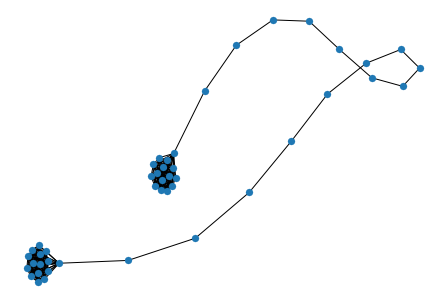

In [2226]:
# new_edges = list(barbell.edges) + list(map(lambda e: (e[0]+n, e[1]+n), barbell.edges)) + [(0, 34)]
# barbell = nx.Graph(new_edges)
nx.draw(barbell, node_size=50, linewidths=0.2)

In [2484]:
import numpy as np
test = nx.complete_graph(15)
# pos = nx.spring_layout(test)
new_pos = {}
# for i in pos:
#     new_pos[i + 30] = pos[i]/5 + 0.3
#     new_pos[i] = pos[i]/5 - 0.5
new_pos = pos


for i in range(15, 30):
    if i < 22:
        new_pos[i] = np.array((0.06*(i-15) -0.2, -0.3))
    elif i == 22:
        new_pos[i] = np.array((0.06 - 0.08, -0.2))
    else:
        new_pos[i] = np.array((0.06*(i-23) -0.2, -0.1))
    # else:
    #     new_pos[i] = np.array((0.05*(i-35), -0.2))
pos= new_pos


from matplotlib import pyplot as plt

plt.figure(figsize=(12, 10), dpi=400)

# pos = nx.fruchterman_reingold_layout(barbell)
nx.draw(barbell,
        pos=pos,
        cmap=plt.cm.rainbow,
        node_size=600,
        node_color=[1]*14 + list(range(14,22)) + [22] + list(range(14,22))[::-1] + [1]*14,
        width=.3,
        font_size=16,
        alpha=1,
        linewidths=0.4,
        edgecolors='black',
        # with_labels=True
        # node_color=list(map(lambda n: color_map[int(roles[n].split('_')[1])], barbell.nodes))
        )

plt.savefig('./barbell.pdf', format='pdf')
plt.savefig('./barbell.eps', bbox_inches='tight')
plt.clf()

<Figure size 4800x4000 with 0 Axes>

In [2468]:
from sklearn.model_selection import train_test_split

x = F.one_hot(torch.arange(barbell.number_of_nodes())).float()
# x = torch.ones(barbell.number_of_nodes(), 16).float()
y = torch.tensor(
    list(map(lambda r: int(roles[r].split('_')[1]),
    barbell.nodes))
)

train_idx, test_idx, _, _ = train_test_split(list(range(barbell.number_of_nodes())), list(range(barbell.number_of_nodes())), test_size=0.4, random_state=42)
val_idx, test_idx, _, _ = train_test_split(test_idx, test_idx, test_size=0.5)


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

train_mask = index_to_mask(torch.tensor(train_idx), y.shape[0])
val_mask = index_to_mask(torch.tensor(val_idx), y.shape[0])
test_mask = index_to_mask(torch.tensor(test_idx), y.shape[0])
print(train_mask.nonzero().shape)

torch.Size([27, 1])


In [2469]:
N = barbell.number_of_nodes()
dropout = 0.
heads = 1
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        adj = torch.sparse_coo_tensor(torch.tensor(list(barbell.edges)).T, torch.ones(barbell.number_of_edges()), (N, N))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, x.shape[1], 64,
                                                 dropout=dropout, out_channels=heads, alpha=0.2, order=16, concat=False)

        self.synthesis = GraphSpectralFilterLayer(self.G, 64 * heads, 16, dropout=dropout,
                                                  out_channels=1, alpha=0.2,
                                                  order=16, concat=False)


        self.linear = torch.nn.Linear(16, y.max()+1, bias=False)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        self.synthesis.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, input):
        x = self.analysis(input)[0]
        x = F.dropout(x, p=dropout, training=self.training)
        x = self.synthesis(x)[0]
        x = F.elu(x)
        embeddings = x
        x = self.linear(x)

        return F.log_softmax(x, dim=1), embeddings, None


In [2470]:
from torch.optim import Adam
from sklearn.metrics import f1_score
import numpy as np

model = Net()

model.reset_parameters()
optimizer = Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
best_val_acc = float(0)
eval_info_early_model = None
bad_counter = 0

masks = {
    'train_mask': train_mask,
    'val_mask': val_mask,
    'test_mask': test_mask,
}

for epoch in range(1, 1000):
    model.train()
    optimizer.zero_grad()
    out = model(x)[0]
    loss = F.nll_loss(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.no_grad():
        logits = model(x)[0]

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = masks['{}_mask'.format(key)]
        loss = F.nll_loss(logits[mask], y[mask]).item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = f1_score(y[mask].cpu(), logits[mask].max(1)[1].cpu(), average='micro')
        outs['{}_macro_f1'.format(key)] = f1_score(y[mask].cpu(), logits[mask].max(1)[1].cpu(), average='macro')

    outs['epoch'] = epoch
    if epoch % 100 == 0:
        print(outs)

    if outs['val_acc'] > best_val_acc or outs['val_loss'] < best_val_loss:
        if outs['val_acc'] >= best_val_acc:
            eval_info_early_model = outs
            torch.save(model.state_dict(), './best_barbell.pkl')
        best_val_acc = np.max((best_val_acc, outs['val_acc']))
        best_val_loss = np.min((best_val_loss, outs['val_loss']))
        bad_counter = 0
    else:
        bad_counter += 1
        if bad_counter == 10:
            break
print(eval_info_early_model)

model.load_state_dict(torch.load('./best_barbell.pkl'))
model.eval()

{'train_loss': 0.11444877088069916, 'train_acc': 0.9629629629629629, 'train_macro_f1': 0.9570747217806042, 'val_loss': 0.060781240463256836, 'val_acc': 1.0, 'val_macro_f1': 1.0, 'test_loss': 0.13429225981235504, 'test_acc': 0.8888888888888888, 'test_macro_f1': 0.8, 'epoch': 100}
{'train_loss': 0.05175449699163437, 'train_acc': 0.9629629629629629, 'train_macro_f1': 0.9570747217806042, 'val_loss': 0.01787823811173439, 'val_acc': 1.0, 'val_macro_f1': 1.0, 'test_loss': 0.0834670290350914, 'test_acc': 1.0, 'test_macro_f1': 1.0, 'epoch': 200}
{'train_loss': 0.034343212842941284, 'train_acc': 1.0, 'train_macro_f1': 1.0, 'val_loss': 0.006428668275475502, 'val_acc': 1.0, 'val_macro_f1': 1.0, 'test_loss': 0.06522863358259201, 'test_acc': 1.0, 'test_macro_f1': 1.0, 'epoch': 300}
{'train_loss': 0.023436401039361954, 'train_acc': 1.0, 'train_macro_f1': 1.0, 'val_loss': 0.002414614660665393, 'val_acc': 1.0, 'val_macro_f1': 1.0, 'test_loss': 0.05423983559012413, 'test_acc': 1.0, 'test_macro_f1': 1.0,

Net(
  (analysis): GraphSpectralFilterLayer (45 -> 64)
  (synthesis): GraphSpectralFilterLayer (64 -> 16)
  (linear): Linear(in_features=16, out_features=2, bias=False)
)

[t-SNE] Computing 44 nearest neighbors...
[t-SNE] Indexed 45 samples in 0.000s...
[t-SNE] Computed neighbors for 45 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 45 / 45
[t-SNE] Mean sigma: 1.467181
[t-SNE] KL divergence after 250 iterations with early exaggeration: 32.061119
[t-SNE] KL divergence after 700 iterations: 0.021115


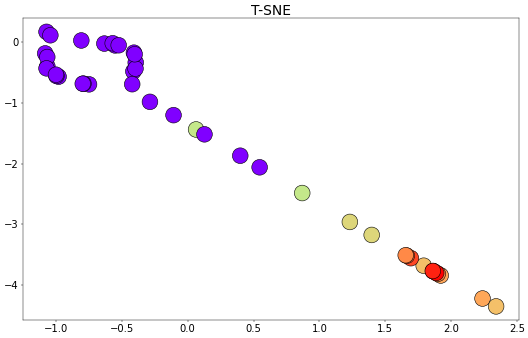

In [2471]:
with torch.no_grad():
    _, embeddings, _ = model(x)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1,n_iter=3000, early_exaggeration=10, learning_rate=30, perplexity=25,)
tsne_results = tsne.fit_transform(embeddings)

import seaborn as sns
df_subset = {}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = [0]*14 + list(range(1,9)) + [9] + list(range(1,9))[::-1] + [0]*14
plt.figure(figsize=(16,10), dpi=40)
plt.scatter(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    # c = [0]*14 + list(range(1,9)) + [9] + list(range(1,9))[::-1] + [0]*14,
    c=[0]*14 + list(range(14,22)) + [22] + list(range(14,22))[::-1] + [0]*14,
    cmap=plt.cm.rainbow,
    linewidths=1,
    edgecolors='black',
    s=800,
)
plt.title("T-SNE", fontsize=25)

locs, labels = plt.xticks(fontsize=18)
locs, labels = plt.yticks(fontsize=18)

In [2472]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(embeddings)
df = {}
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
df['y'] = list(roles.values())
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [9.36074651e-01 6.37497490e-02 8.42828143e-05]


In [2482]:
plt.figure(figsize=(12, 10), dpi=400)
plt.scatter(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    # c = [0]*14 + list(range(1,9)) + [9] + list(range(1,9))[::-1] + [0]*14,
    c=[0]*14 + list(range(14,22)) + [22] + list(range(14,22))[::-1] + [0]*14,
    cmap=plt.cm.rainbow,
    linewidths=1,
    edgecolors='black',
    s=800,
)

locs, labels = plt.xticks(fontsize=18)
locs, labels = plt.yticks(fontsize=18)
plt.xlabel("PCA 1", fontsize=25)
plt.ylabel("PCA 2", fontsize=25)

plt.savefig('./barbell_pca.pdf', format='pdf')
plt.savefig('./barbell_pca.eps', bbox_inches='tight')
plt.clf()

<Figure size 4800x4000 with 0 Axes>